In [1]:
import warnings
import os
from time import time
from datetime import datetime

from google.colab import drive
from google.colab import auth
from googleapiclient.discovery import build
from IPython.core.magic import register_cell_magic

import json
import pickle
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoConfig

import torch
from torch import optim, nn
from torch.utils.data import Dataset, DataLoader

# Docs

## Models

**GPT Conversation -** https://chatgpt.com/share/681dfabb-27dc-800f-9b96-654eb3812160

**List -** https://huggingface.co/transformers/v3.3.1/pretrained_models.html

### Albert - More efficient and scalable


### Bart - 1024 context length

### CamemBERT - French

### DistilBERT - Small and efficient

### ELECTRA - Learn from all tokens

### FlauBERT - More French

### Funnel Transformer - Efficient

### MobileBERT - Super Cheap

### RoBERTa - Better

### XLM - Multilingual

### XLM-RoBERTa - Multilingual Better

### XLNet - long-range dependencies

## Optimizers

**List -** https://docs.pytorch.org/docs/stable/optim.html#algorithms

## Loss Functions

**List -** https://docs.pytorch.org/docs/stable/nn.html#loss-functions

# Configure

In [2]:
NAME = 'Bert 7.0'

PATH = '/content/drive/My Drive/DS Final Project/BERT Model/'

DATASET = 'enron_sentiment_full.parquet'
TEXT_COLUMN = 'email'
LABEL_COLUMN = 'sentiment'
MAX_GROUP_SIZE = 10000
MAX_TOKEN_LENGTH = 512
BATCH_SIZE = 8

MODEL = 'bert-base-uncased'
OPTIMIZER = 'AdamW'
WEIGHT_DECAY = 0.1
CRITERION = 'CrossEntropyLoss'
LABEL_SMOOTHING = 0.1
DROPOUT_PROB = 0.4
LEARNING_RATE = 2e-5
FREEZE_LAYERS = 6

SKIP_TRAIN = True
NUM_EPOCHS = 20

In [3]:
SKIP_INFERENCE = True

INFERENCE_FILE = 'Sentiment Analysis Benchmark.csv'
INFERENCE_TEXT_COLUMN = 'email'
INFERENCE_LABEL_COLUMN = 'Sentiment by '

BENCHMARK_FILE = 'Sentiment Analysis Benchmark.csv'
BENCHMARK_LABEL_COLUMN = 'sentiment'

In [4]:
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
start_time = time()
drive.mount('/content/drive', force_remount=True)
auth.authenticate_user()
drive_service = build('drive', 'v3')

Mounted at /content/drive


## Save and Load

In [5]:
model_dir = PATH + 'Models/Model - ' + NAME
os.makedirs(model_dir, exist_ok=True)

if os.path.exists(model_dir + '/config.json'):
    with open(model_dir + '/config.json', 'r') as f:
        config = json.load(f)

    DATASET = config['DATASET']
    MAX_TOKEN_LENGTH = config['MAX_TOKEN_LENGTH']
    LEARNING_RATE = config['LEARNING_RATE']
    DROPOUT_PROB = config['DROPOUT_PROB']
    MODEL = config['MODEL']

    try:
      OPTIMIZER = config['OPTIMIZER']
      CRITERION = config['CRITERION']
    except:
      pass

    try:
      WEIGHT_DECAY = config['WEIGHT_DECAY']
      LABEL_SMOOTHING = config['LABEL_SMOOTHING']
      FREEZE_LAYERS = config['FREEZE_LAYERS']
    except:
      pass

    print('Loaded config from', model_dir + '/config.json')
    print('WARNING - Config overridden!')
else:
  with open(model_dir + '/config.json', 'w') as f:
      json.dump({
          'DATASET': DATASET,
          'MAX_TOKEN_LENGTH': MAX_TOKEN_LENGTH,
          'LEARNING_RATE': LEARNING_RATE,
          'DROPOUT_PROB': DROPOUT_PROB,
          'MODEL': MODEL,
          'OPTIMIZER': OPTIMIZER,
          'CRITERION': CRITERION,
          'WEIGHT_DECAY': WEIGHT_DECAY,
          'LABEL_SMOOTHING': LABEL_SMOOTHING,
          'FREEZE_LAYERS': FREEZE_LAYERS
      }, f, indent=4)
  print('Saved config to', model_dir + '/config.json')

Loaded config from /content/drive/My Drive/DS Final Project/BERT Model/Models/Model - Bert 7.0/config.json
WARNING - Config overridden!


## Functions

In [6]:
class ClassifierDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

In [7]:
def plot_graph(eval_train, eval_test, title):
    plt.figure(figsize = (13,6))
    plt.plot(eval_train)
    plt.plot(eval_test)
    plt.title('model ' + title)
    plt.ylabel(title)
    plt.xlabel('epoch')
    plt.locator_params(axis="x", integer=True, tight=True)
    plt.legend(['train', 'val'], loc='upper left')

In [8]:
def plot_confusion_matrix(y_true, y_pred, figsize=(6, 5), cmap="Blues"):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, xticklabels=map_classes.classes_, yticklabels=map_classes.classes_)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

In [9]:
def compute_accuracy(preds, labels):
    return (preds == labels).float().mean().item()

In [10]:
@register_cell_magic
def skip(line, cell):
    if eval(line):
        return
    exec(cell, globals())

In [11]:
def get_optimizer(name: str, params, **kwargs):
    try:
        optimizer_class = getattr(optim, name)
    except AttributeError:
        raise ValueError(f"Optimizer '{name}' is not available in torch.optim.")
    return optimizer_class(params, **kwargs)

In [12]:
def get_criterion(name: str, **kwargs):
    try:
        criterion_class = getattr(nn, name)
    except AttributeError:
        raise ValueError(f"Criterion '{name}' is not available in torch.nn.")
    return criterion_class(**kwargs)

# Prepare Data

## Load Saved Data

In [13]:
model_dir = PATH + 'Models/Model - ' + NAME
os.makedirs(model_dir, exist_ok=True)

loaded_data = False

if os.path.exists(model_dir + '/data.pkl') and os.path.exists(model_dir + '/mapped_classes.pkl'):
    with open(model_dir + '/data.pkl', 'rb') as file:
      data = pickle.load(file)

    X_train_encoded = data["train"]['x']
    y_train = data["train"]['y']

    X_val_encoded = data["val"]['x']
    y_val = data["val"]['y']

    X_test_encoded = data["test"]['x']
    y_test = data["test"]['y']

    print('Loaded data from', model_dir + '/data.pkl')

    with open(model_dir + '/mapped_classes.pkl', 'rb') as f:
        map_classes = pickle.load(f)

    print('Loaded classes from', model_dir + '/mapped_classes.pkl')

    loaded_data = True

Loaded data from /content/drive/My Drive/DS Final Project/BERT Model/Models/Model - Bert 7.0/data.pkl
Loaded classes from /content/drive/My Drive/DS Final Project/BERT Model/Models/Model - Bert 7.0/mapped_classes.pkl


## Read Data

In [14]:
%%skip loaded_data

if DATASET.endswith(".csv"):
  raw_df = pd.read_csv(PATH + 'Data/' + DATASET)
else:
  raw_df = pd.read_parquet(PATH + 'Data/' + DATASET)

if 'text' not in raw_df.columns:
    raw_df.rename(columns={TEXT_COLUMN: 'text'}, inplace=True)

if 'label' not in raw_df.columns:
    raw_df.rename(columns={LABEL_COLUMN: 'label'}, inplace=True)

df = raw_df[['text', 'label']]

In [15]:
%%skip loaded_data

df = df.groupby('text', as_index=False).first()

group_size = min(df.groupby('label').size().min(), MAX_GROUP_SIZE)

df = df.groupby('label').head(group_size)

print(f'Saved {group_size} samples from each class.')

In [16]:
%%skip loaded_data

map_classes = LabelEncoder()
df['label'] = map_classes.fit_transform(df['label'])

## Split Data

In [17]:
%%skip loaded_data

X_df = df['text']
y_df = df['label']

In [18]:
%%skip loaded_data

x_train, x_test_val, y_train, y_test_val = train_test_split(X_df, y_df, test_size=0.2, stratify = y_df)
x_val, x_test, y_val, y_test = train_test_split(x_test_val, y_test_val, test_size=0.5, stratify = y_test_val)

In [19]:
%%skip loaded_data

y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

## Tokenize

In [20]:
tokenizer = AutoTokenizer.from_pretrained(MODEL, do_lower_case=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [21]:
%%skip loaded_data

X_train_encoded = tokenizer.batch_encode_plus(x_train.tolist(), padding=True, truncation=True, max_length = MAX_TOKEN_LENGTH, return_tensors='pt')

X_val_encoded = tokenizer.batch_encode_plus(x_val.tolist(), padding=True, truncation=True, max_length = MAX_TOKEN_LENGTH, return_tensors='pt')

X_test_encoded = tokenizer.batch_encode_plus(x_test.tolist(), padding=True, truncation=True, max_length = MAX_TOKEN_LENGTH, return_tensors='pt')

## Save Data

In [22]:
%%skip loaded_data

model_dir = PATH + '/Models/Model - ' + NAME
os.makedirs(model_dir, exist_ok=True)

data = {}

data["train"] = {'x': X_train_encoded, 'y': y_train}
data["val"] = {'x': X_val_encoded, 'y': y_val}
data["test"] = {'x': X_test_encoded, 'y': y_test}

with open(model_dir + '/data.pkl', 'wb') as f:
    pickle.dump(data, f)

with open(model_dir + '/mapped_classes.pkl', 'wb') as f:
    pickle.dump(map_classes, f)

# Model

In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [24]:
train_dataset = ClassifierDataset(X_train_encoded, y_train)
val_dataset = ClassifierDataset(X_val_encoded, y_val)
test_dataset = ClassifierDataset(X_test_encoded, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

## Train

In [25]:
config = AutoConfig.from_pretrained(MODEL)

config.num_labels=len(map_classes.classes_)

attrs = dir(config)
dropouts = [a for a in attrs if 'dropout' in a]
for attr in dropouts:
    setattr(config, attr, DROPOUT_PROB)

print('Set the following dropouts:', dropouts)
print('To:', DROPOUT_PROB)

Set the following dropouts: ['attention_probs_dropout_prob', 'classifier_dropout', 'hidden_dropout_prob']
To: 0.3


In [26]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL, config=config).to(device)
optimizer = get_optimizer(OPTIMIZER, model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
criterion = get_criterion(CRITERION, label_smoothing=LABEL_SMOOTHING)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
for layer in model.bert.encoder.layer[:FREEZE_LAYERS]:
    for param in layer.parameters():
        param.requires_grad = False


In [28]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
start_epoch = 0

best_loss = 0
best_acc = 0
best_epoch = 0

checkpoint_dir = PATH + 'Checkpoints/Model - ' + NAME
best_epoch_path = os.path.join(checkpoint_dir, f"best_epoch.pt")
best_epoch_path

'/content/drive/My Drive/DS Final Project/BERT Model/Checkpoints/Model - Bert 7.0/best_epoch.pt'

In [29]:
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_files = [f for f in os.listdir(checkpoint_dir) if f.startswith("model_epoch_")]
if checkpoint_files:
    last_epoch = max([int(f.split('_')[-1].split('.')[0]) for f in checkpoint_files])
    checkpoint_path = os.path.join(checkpoint_dir, f"model_epoch_{last_epoch}.pt")
    checkpoint = torch.load(checkpoint_path)

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    train_losses = checkpoint['train_losses']
    val_losses = checkpoint['val_losses']
    train_accuracies = checkpoint['train_accuracies']
    val_accuracies = checkpoint['val_accuracies']
    start_epoch = checkpoint['epoch'] + 1

    print(f"Resumed from epoch {start_epoch}")

Resumed from epoch 100


In [30]:
if start_epoch > 0:
  best_epoch_checkpoint = torch.load(best_epoch_path)
  best_loss = best_epoch_checkpoint['val_losses'][-1]
  best_acc = best_epoch_checkpoint['val_accuracies'][-1]
  best_epoch = best_epoch_checkpoint['epoch']

In [31]:
%%skip SKIP_TRAIN

for epoch in tqdm(range(start_epoch, NUM_EPOCHS), desc="Training"):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0

    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        output = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(output.logits, dim=1)
        loss = criterion(output.logits, labels)
        acc = compute_accuracy(preds, labels)

        running_loss += loss.item()
        running_accuracy += acc

        loss.backward()
        optimizer.step()

    avg_train_loss = running_loss / len(train_loader)
    avg_train_accuracy = running_accuracy / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_accuracy)

    model.eval()
    running_loss = 0.0
    running_accuracy = 0.0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            output = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(output.logits, dim=1)
            loss = criterion(output.logits, labels)
            acc = compute_accuracy(preds, labels)
            running_loss += loss.item()
            running_accuracy += acc

    avg_val_loss = running_loss / len(val_loader)
    avg_val_accuracy = running_accuracy / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_accuracy)

    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies
    }

    checkpoint_path = os.path.join(checkpoint_dir, f"model_epoch_{epoch}.pt")
    torch.save(checkpoint, checkpoint_path)

    if (epoch == 0) or ((best_acc < avg_val_accuracy) or (avg_val_accuracy == best_acc and best_loss >= avg_val_loss)):
      torch.save(checkpoint, best_epoch_path)
      best_loss = val_losses[-1]
      best_acc = val_accuracies[-1]
      best_epoch = epoch

    if epoch > 0:
      last_checkpoint_path = os.path.join(checkpoint_dir, f"model_epoch_{epoch - 1}.pt")
      os.remove(last_checkpoint_path)
      drive_service.files().emptyTrash().execute()

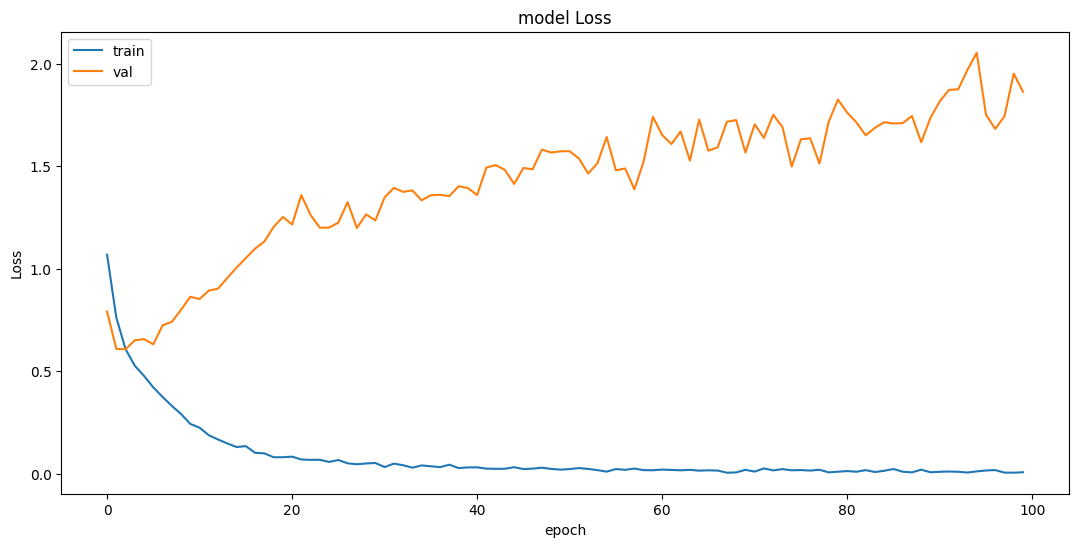

In [32]:
plot_graph(train_losses, val_losses, 'Loss')

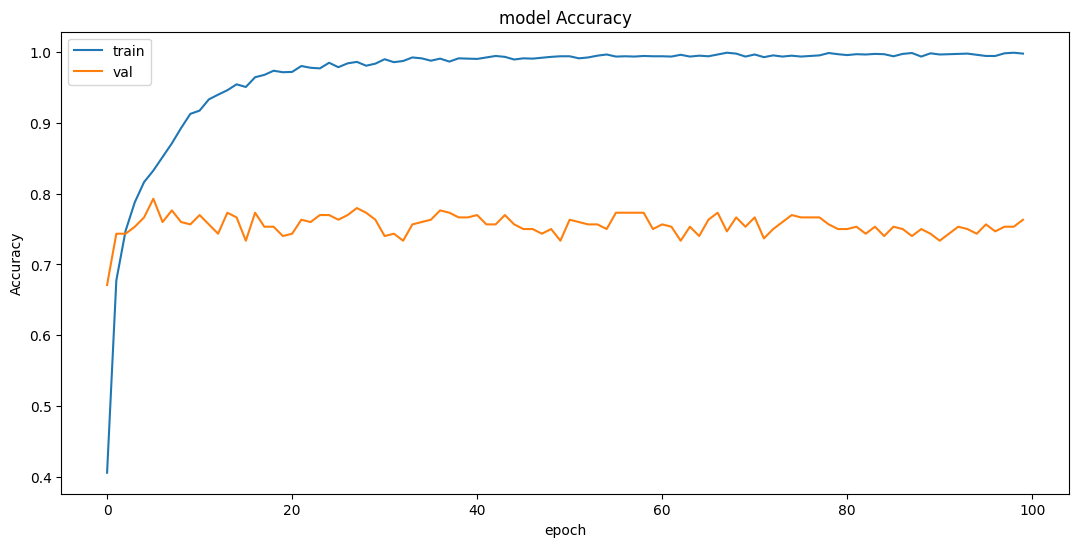

In [33]:
plot_graph(train_accuracies, val_accuracies, 'Accuracy')

## Evaluate

In [34]:
best_model = torch.load(best_epoch_path, map_location=torch.device('cpu'))

model.load_state_dict(best_model['model_state_dict'])
best_model_epoch = best_model['epoch']
print(f"Loaded best model from epoch {best_model_epoch}")

Loaded best model from epoch 5


In [35]:
model.eval()
total_loss = 0.0
total_accuracy = 0.0
total_batches = 0
pred_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        predictions = torch.argmax(outputs.logits, dim=1)
        pred_labels.extend(predictions.tolist())

        loss = criterion(outputs.logits, labels)
        acc = compute_accuracy(predictions, labels)

        total_loss += loss.item()
        total_accuracy += acc
        total_batches += 1

test_loss = total_loss / total_batches
test_accuracy = total_accuracy / total_batches

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.7907, Test Accuracy: 0.7763


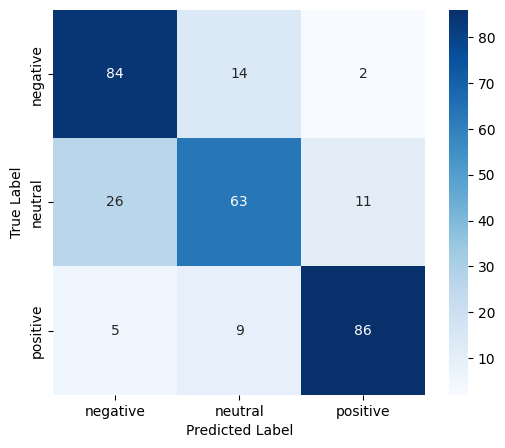

In [36]:
plot_confusion_matrix(y_test, pred_labels)

In [37]:
print("Classification Report: \n", classification_report(y_test, pred_labels))

Classification Report: 
               precision    recall  f1-score   support

           0       0.73      0.84      0.78       100
           1       0.73      0.63      0.68       100
           2       0.87      0.86      0.86       100

    accuracy                           0.78       300
   macro avg       0.78      0.78      0.77       300
weighted avg       0.78      0.78      0.77       300



# Wrap-Up

In [ ]:
model_dir = PATH + '/Models/Model - ' + NAME
os.makedirs(model_dir, exist_ok=True)

tokenizer.save_pretrained(model_dir +'/Tokenizer')

model.save_pretrained(model_dir +'/Model')

In [ ]:
def classify(text, Tokenizer=tokenizer, Model=model, Classes=map_classes, Max_input_len=MAX_TOKEN_LENGTH):
    encoded_text = Tokenizer.batch_encode_plus([text], padding=True, truncation=True, max_length=Max_input_len, return_tensors='pt')

    model.eval()
    with torch.no_grad():
        input_ids = encoded_text['input_ids'].to(device)
        attention_mask = encoded_text['attention_mask'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        predictions = torch.argmax(outputs.logits, dim=1)
        return  Classes.inverse_transform([predictions.item()])[0]

In [ ]:
end_time = time()

In [ ]:
print('Notebook ran for', round((end_time - start_time) / 60), 'minutes')

# Inference

## Load

In [ ]:
model_dir = PATH + '/Models/Model - ' + NAME

saved_tokenizer = AutoTokenizer.from_pretrained(model_dir +'/Tokenizer')

saved_model = AutoModelForSequenceClassification.from_pretrained(model_dir +'/Model')

with open(model_dir + '/mapped_classes.pkl', 'rb') as f:
    classes = pickle.load(f)

## Inference File

In [ ]:
%%skip SKIP_INFERENCE

inference_df = pd.read_csv(PATH + INFERENCE_FILE)

In [ ]:
%%skip SKIP_INFERENCE

inference_df[INFERENCE_LABEL_COLUMN + NAME] = inference_df[INFERENCE_TEXT_COLUMN].apply(lambda text: classify(text, Tokenizer=saved_tokenizer, Model=saved_model, Classes=classes))

In [ ]:
%%skip SKIP_INFERENCE

inference_df.to_csv(PATH + INFERENCE_FILE, index=False)

## Inference String

In [ ]:
text = '''
I am writing to my deep frustration regarding the ongoing issues with [specific issue]. Despite multiple attempts to address this, there has been no satisfactory progress or resolution.

This lack of attention to a critical problem is unacceptable and is affecting our ability to move forward effectively. I expect this matter to be treated with the urgency it deserves and I would appreciate a prompt response outlining how you intend to resolve this issue.

This cannot continue any longer, and I trust you will handle this with the seriousness it warrants.'''
classify(text, Tokenizer=saved_tokenizer, Model=saved_model, Classes=classes)

# Benchmark

## Load Benchmark File

In [ ]:
%%skip SKIP_INFERENCE

benchmark_df = pd.read_csv(PATH + BENCHMARK_FILE)

In [ ]:
%%skip SKIP_INFERENCE

model_names = [col for col in benchmark_df.columns if col.startswith(INFERENCE_LABEL_COLUMN)]

benchmark_df[BENCHMARK_LABEL_COLUMN] = benchmark_df[BENCHMARK_LABEL_COLUMN].str.lower()

for model_name in model_names:
    benchmark_df[model_name] = benchmark_df[model_name].str.lower()

## Compare Models

In [ ]:
%%skip SKIP_INFERENCE

accuracies = {}

for model_name in model_names:
    print(model_name + '\n', classification_report(benchmark_df[BENCHMARK_LABEL_COLUMN], benchmark_df[model_name]))
    plot_confusion_matrix(benchmark_df[BENCHMARK_LABEL_COLUMN], benchmark_df[model_name])
    plt.show()
    accuracies[model_name[13:]] = accuracy_score(benchmark_df[BENCHMARK_LABEL_COLUMN], benchmark_df[model_name])

In [ ]:
%%skip SKIP_INFERENCE

plt.bar(accuracies.keys(), accuracies.values())
plt.ylabel('Accuracy')
plt.title('Accuracy by Model')
plt.xticks(rotation=90, ha='right')
plt.ylim(0, 1)

plt.show()